In [2]:
"""
heart_disease_pipeline.py
"""

import os
import json
import joblib
import warnings
from datetime import datetime

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             mean_squared_error, RocCurveDisplay)

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#import XGBoost
try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except Exception:
    HAS_XGB = False

# ----------------- Config -----------------
DATA_PATH = "heart_disease_uci.csv"
OUTPUT_DIR = "output"
TARGET_COL = 'num'
RANDOM_STATE = 42
TEST_SIZE = 0.20
CV_FOLDS = 5
N_JOBS = -1

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ----------------- Helpers -----------------
def save_json(obj, fname):
    with open(os.path.join(OUTPUT_DIR, fname), 'w') as f:
        json.dump(obj, f, indent=2)

def save_text(text, fname):
    with open(os.path.join(OUTPUT_DIR, fname), 'w') as f:
        f.write(text)

def plot_and_save_roc(y_true, y_score, label, fname):
    try:
        disp = RocCurveDisplay.from_predictions(y_true, y_score)
        plt.title(f"ROC Curve - {label}")
        plt.savefig(os.path.join(OUTPUT_DIR, fname), bbox_inches='tight')
        plt.close()
    except Exception as e:
        print("ROC plot failed:", e)

def compute_rmse_prob(y_true, y_prob):
    return float(np.sqrt(mean_squared_error(y_true, y_prob)))

# ----------------- Load Data -----------------
print("Loading dataset...")
df = pd.read_csv(DATA_PATH)
print("Original shape:", df.shape)

if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found.")

# Use all features except target
SELECTED_FEATURES = [c for c in df.columns if c != TARGET_COL]

X = df[SELECTED_FEATURES].copy()
y = df[TARGET_COL].astype(int)

# Convert multi-valued target to binary
if y.nunique() > 2:
    y = (y > 0).astype(int)

df = df.dropna(how='all')
print("After dropping empty rows shape:", df.shape)

# ----------------- Preprocessing -----------------
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [c for c in SELECTED_FEATURES if c not in numeric_cols]

# Treat numeric columns with few unique values as categorical
for col in numeric_cols.copy():
    if X[col].nunique() <= 6:
        numeric_cols.remove(col)
        cat_cols.append(col)

print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, cat_cols)
], remainder='drop')

# ----------------- Train/Test Split -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)
print("Train/test shapes:", X_train.shape, X_test.shape)

# ----------------- Models & Parameter Grids -----------------
models = {
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE)
}
if HAS_XGB:
    models["XGBoost"] = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE)

param_grids = {
    "DecisionTree": {'clf__max_depth': [None, 3, 5, 8], 'clf__min_samples_split': [2, 5, 10]},
    "LogisticRegression": {'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['liblinear']},
    "RandomForest": {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 6, 12], 'clf__min_samples_split': [2, 5], 'clf__min_samples_leaf': [1, 2]}
}
if HAS_XGB:
    param_grids["XGBoost"] = {'clf__n_estimators': [100, 200], 'clf__max_depth': [3, 6],
                              'clf__learning_rate': [0.01, 0.1], 'clf__subsample': [0.6, 0.8, 1.0]}

# ----------------- Training & Evaluation -----------------
results_summary = {}
best_estimators = {}
skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, estimator in models.items():
    print("\n", "="*50)
    print(f"Processing model: {name}")

    pipe = Pipeline([("preprocessor", preprocessor), ("clf", estimator)])
    param_grid = param_grids.get(name, None)

    if param_grid:
        search = GridSearchCV(pipe, param_grid, scoring="f1", cv=skf, n_jobs=N_JOBS) if name in ("DecisionTree", "LogisticRegression") \
                 else RandomizedSearchCV(pipe, param_grid, n_iter=20, scoring="f1", cv=skf, n_jobs=N_JOBS, random_state=RANDOM_STATE)
        search.fit(X_train, y_train)
        best = search.best_estimator_
        print(" - Best params:", search.best_params_)
    else:
        pipe.fit(X_train, y_train)
        best = pipe

    best_estimators[name] = best

    y_pred = best.predict(X_test)
    try:
        y_prob = best.predict_proba(X_test)[:, 1]
    except:
        if hasattr(best.named_steps['clf'], "decision_function"):
            y_prob = 1 / (1 + np.exp(-best.named_steps['clf'].decision_function(X_test)))
        else:
            y_prob = y_pred.astype(float)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    try:
        roc = roc_auc_score(y_test, y_prob)
    except:
        roc = None
    rmse = compute_rmse_prob(y_test, y_prob)

    metrics = {"accuracy": float(acc), "precision": float(prec), "recall": float(rec),
               "f1_score": float(f1), "roc_auc": roc, "rmse_prob": rmse}
    print(f"Metrics for {name}:", metrics)
    results_summary[name] = metrics

    # Save artifacts
    save_text(classification_report(y_test, y_pred, zero_division=0), f"{name}_classification_report.txt")
    save_json({"confusion_matrix": confusion_matrix(y_test, y_pred).tolist()}, f"{name}_confusion_matrix.json")
    if roc is not None:
        plot_and_save_roc(y_test, y_prob, name, f"{name}_roc.png")
    joblib.dump(best, os.path.join(OUTPUT_DIR, f"{name}_best.joblib"))

# ----------------- Cross-validation summary -----------------
cv_results = {}
for name, est in best_estimators.items():
    try:
        scores = cross_val_score(est, X, y, cv=skf, scoring="f1", n_jobs=N_JOBS)
        cv_results[name] = {"cv_f1_mean": float(np.mean(scores)), "cv_f1_std": float(np.std(scores)),
                            "fold_scores": [float(s) for s in scores]}
    except Exception as e:
        cv_results[name] = {"error": str(e)}

# ----------------- Save summaries -----------------
timestamp = datetime.now().isoformat()
summary = {
    "timestamp": timestamp,
    "selected_features": SELECTED_FEATURES,
    "n_rows": int(df.shape[0]),
    "models_evaluated": list(results_summary.keys()),
    "results": results_summary,
    "cv_summary": cv_results
}
save_json(summary, "pipeline_summary.json")
for name, metrics in results_summary.items():
    save_json(metrics, f"{name}_metrics.json")

readme = f"""Heart Disease ML Pipeline Outputs
Generated: {timestamp}

Files:
- pipeline_summary.json
- <Model>_metrics.json
- <Model>_classification_report.txt
- <Model>_confusion_matrix.json
- <Model>_roc.png
- <Model>_best.joblib
Selected features: {SELECTED_FEATURES}
"""
save_text(readme, "README_RESULTS.txt")

print("\nAll done. Files saved to:", OUTPUT_DIR)
print("Summary (console):")
print(json.dumps(summary, indent=2))


Loading dataset...
Original shape: (920, 16)
After dropping empty rows shape: (920, 16)
Numeric cols: ['id', 'age', 'trestbps', 'chol', 'thalch', 'oldpeak']
Categorical cols: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal', 'ca']
Train/test shapes: (736, 15) (184, 15)

Processing model: DecisionTree
 - Best params: {'clf__max_depth': 5, 'clf__min_samples_split': 10}
Metrics for DecisionTree: {'accuracy': 0.8641304347826086, 'precision': 0.8737864077669902, 'recall': 0.8823529411764706, 'f1_score': 0.8780487804878049, 'roc_auc': np.float64(0.9219273075083692), 'rmse_prob': 0.3313210807407576}

Processing model: LogisticRegression
 - Best params: {'clf__C': 10, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Metrics for LogisticRegression: {'accuracy': 0.8586956521739131, 'precision': 0.8518518518518519, 'recall': 0.9019607843137255, 'f1_score': 0.8761904761904762, 'roc_auc': np.float64(0.9422525107604017), 'rmse_prob': 0.30115378154336325}

Processing model: Random

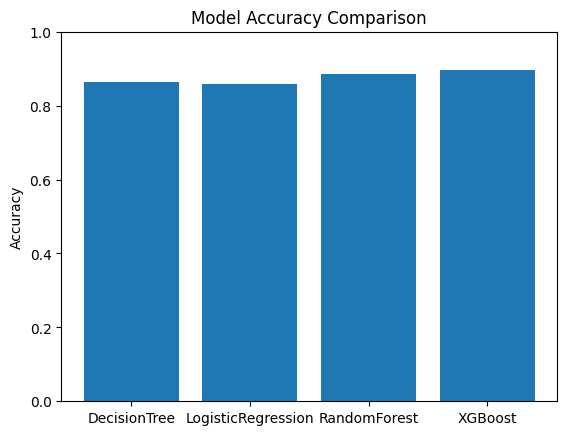

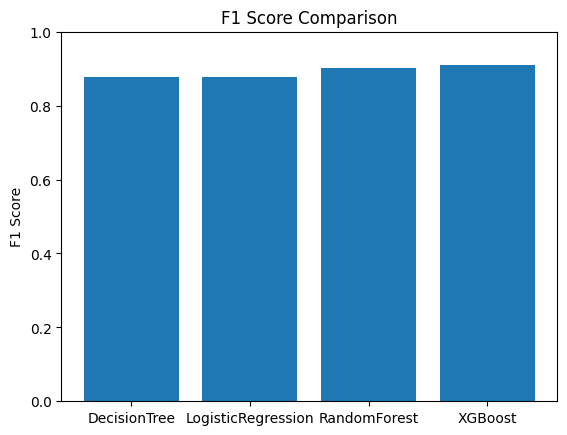

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Extract metrics from results
model_names = list(results_summary.keys())
acc_scores = [results_summary[m]['accuracy'] for m in model_names]
f1_scores = [results_summary[m]['f1_score'] for m in model_names]
roc_scores = [results_summary[m]['roc_auc'] for m in model_names]

# 1. Accuracy Comparison
plt.figure()
plt.bar(model_names, acc_scores)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.savefig(os.path.join(OUTPUT_DIR, "accuracy_comparison.png"))
plt.show()

#  2. F1 Score Comparison
plt.figure()
plt.bar(model_names, f1_scores)
plt.title("F1 Score Comparison")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.savefig(os.path.join(OUTPUT_DIR, "f1_comparison.png"))
plt.show()

In [ ]:
"""
heart_disease_predict.py
Load trained model and predict heart disease from user input.
"""

import os
import joblib
import pandas as pd

# ----------------- Load model -----------------
OUTPUT_DIR = "output"
model_files = [f for f in os.listdir(OUTPUT_DIR) if f.endswith("_best.joblib")]
if not model_files:
    raise FileNotFoundError(f"No *_best.joblib found in {OUTPUT_DIR}")

MODEL_FILE = os.path.join(OUTPUT_DIR, model_files[0])
print("Loading model:", MODEL_FILE)
model = joblib.load(MODEL_FILE)

# ----------------- Features & Defaults -----------------
FEATURES = ['age','sex','cp','trestbps','chol','fbs','restecg',
            'thalach','exang','oldpeak','slope','ca','thal','dataset','id','thalch']

NUMERIC_DEFAULTS = {
    'age': 50, 'trestbps': 120, 'chol': 200, 'thalach': 150,
    'oldpeak': 1.0, 'ca': 0, 'thalch': 150, 'id': 0, 'dataset':0
}

CATEGORICAL_DEFAULTS = {
    'sex': 1, 'cp': 1, 'fbs':0, 'restecg':0, 'exang':0, 'slope':2, 'thal':3
}

SEX_MAP = {"male": 1, "female": 2}
CP_MAP = {"typical angina": 1, "atypical angina": 2, "non-anginal pain": 3, "asymptomatic": 4}
FBS_MAP = {"yes":1, "no":0}
RESTECG_MAP = {"normal":0, "st-t abnormality":1, "left ventricular hypertrophy":2}
EXANG_MAP = {"yes":1, "no":0}
SLOPE_MAP = {"upsloping":1, "flat":2, "downsloping":3}
THAL_MAP = {"normal":3, "fixed defect":6, "reversible defect":7}

# ----------------- User Input -----------------
def get_user_input():
    print("Enter patient details (leave blank for default):\n")
    user_input = {}

    user_input['age'] = int(input(f"Age [{NUMERIC_DEFAULTS['age']}]: ") or NUMERIC_DEFAULTS['age'])
    sex = input("Sex (male/female) [male]: ").strip().lower()
    user_input['sex'] = SEX_MAP.get(sex, CATEGORICAL_DEFAULTS['sex'])

    print("Chest Pain Type options: typical angina, atypical angina, non-anginal pain, asymptomatic")
    cp = input("Chest Pain Type [typical angina]: ").strip().lower()
    user_input['cp'] = CP_MAP.get(cp, CATEGORICAL_DEFAULTS['cp'])

    user_input['trestbps'] = int(input(f"Resting BP [{NUMERIC_DEFAULTS['trestbps']}]: ") or NUMERIC_DEFAULTS['trestbps'])
    user_input['chol'] = int(input(f"Cholesterol [{NUMERIC_DEFAULTS['chol']}]: ") or NUMERIC_DEFAULTS['chol'])

    fbs = input("Fasting Blood Sugar >120mg/dl (yes/no) [no]: ").strip().lower()
    user_input['fbs'] = FBS_MAP.get(fbs, CATEGORICAL_DEFAULTS['fbs'])

    restecg = input("Resting ECG (normal, ST-T abnormality, left ventricular hypertrophy) [normal]: ").strip().lower()
    user_input['restecg'] = RESTECG_MAP.get(restecg, CATEGORICAL_DEFAULTS['restecg'])

    user_input['thalach'] = int(input(f"Max Heart Rate [{NUMERIC_DEFAULTS['thalach']}]: ") or NUMERIC_DEFAULTS['thalach'])

    exang = input("Exercise Induced Angina (yes/no) [no]: ").strip().lower()
    user_input['exang'] = EXANG_MAP.get(exang, CATEGORICAL_DEFAULTS['exang'])

    user_input['oldpeak'] = float(input(f"ST Depression [{NUMERIC_DEFAULTS['oldpeak']}]: ") or NUMERIC_DEFAULTS['oldpeak'])

    slope = input("Slope (upsloping, flat, downsloping) [flat]: ").strip().lower()
    user_input['slope'] = SLOPE_MAP.get(slope, CATEGORICAL_DEFAULTS['slope'])

    user_input['ca'] = int(input(f"Major vessels colored (0-3) [{NUMERIC_DEFAULTS['ca']}]: ") or NUMERIC_DEFAULTS['ca'])

    thal = input("Thalassemia (normal, fixed defect, reversible defect) [normal]: ").strip().lower()
    user_input['thal'] = THAL_MAP.get(thal, CATEGORICAL_DEFAULTS['thal'])

    # Optional fields
    user_input['dataset'] = NUMERIC_DEFAULTS['dataset']
    user_input['id'] = NUMERIC_DEFAULTS['id']
    user_input['thalch'] = user_input['thalach']

    return user_input

# ----------------- Prediction -----------------
def predict_heart_disease(user_input):
    df = pd.DataFrame([user_input])[FEATURES]
    pred = model.predict(df)[0]
    try:
        prob = model.predict_proba(df)[:,1][0]
    except:
        prob = float(pred)
    result = "Heart Disease DETECTED" if pred==1 else "No Heart Disease"
    return result, prob

# ----------------- Main -----------------
if __name__ == "__main__":
    user_data = get_user_input()
    result, probability = predict_heart_disease(user_data)

    print("\n--- Prediction Result ---")
    print("Prediction:", result)
    print("Probability of having heart disease:", round(probability,2))


Loading model: output/RandomForest_best.joblib
Enter patient details (leave blank for default):

